In [1]:
import os
import sys

# Import Code modules
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from data_fetcher import DataFetcher
from endpoint_type import EndpointType
from db_connector import DBConnector
from flusurv_params import *
from fluview_params import *
from gft_params import *

db_connector = DBConnector()

In [3]:
import requests
import pandas as pd
import numpy as np
import sqlalchemy as sqla
import requests_cache
import plotnine as p9
import datetime as date
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_rows", None)
requests_cache.install_cache('covidcast_cache')

## **1 Regional Distribution of Influenza Cases**

**1.1 Regional Distribution**

In [99]:
fluview_param = FluViewParams(
    epiweeks = ["202001-202053"],
    regions = [FluViewRegion.HHS1,FluViewRegion.HHS2,FluViewRegion.HHS3,FluViewRegion.HHS4,FluViewRegion.HHS5,FluViewRegion.HHS6,FluViewRegion.HHS7,FluViewRegion.HHS8,FluViewRegion.HHS9,FluViewRegion.HHS10]
)

region_df = DataFetcher.fetch(
    endpoint = EndpointType.FLUVIEW, 
    param = fluview_param
)


In [154]:
query = f"""
SELECT region, SUM(num_ili) AS num_iliness FROM {DBConnector.resolveTableName(EndpointType.FLUVIEW)} GROUP BY region
"""

hhs_df = db_connector.read(query)
hhs_df = hhs_df.loc[hhs_df['region']!='cen2']
hhs_df['region']=['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco']


We adopted HHS regions in this analysis where HHS1 includes Connecticut, Maine, Massachusetts, and New Hampshire Rhode Island, Vermont (Boston Region), HHS2 includes New Jersey, New York, Puerto Rico, and U.S. Virgin Islands (New York Region), HHS3 includes Delaware, District of Columbia,Maryland, Pennsylvania, Virginia, West Virginia (Philadelphia Region), HH4 includes Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, Tennessee (Atlanta Region), HHS5 includes Illinois, Indiana, Michigan, Minnesota, Ohio, Wisconsin (Chicago Region), HHS6 includes Arkansas, Louisiana, New Mexico, Oklahoma, Texas (Dallas Region), HHS 7 includes Iowa, Kansas, Missouri, Nebraska (Kansas City Region), HHS8 includes Colorado, Montana, North Dakota, South Dakota, Utah, Wyoming (Denver Region), HHS9 includes American Samoa, Arizona, California, Commonwealth of the Northern Mariana Islands, Guam, Hawaii, Nevada, Republic of Palau, Republic of the Marshall Islands (San Francisco Region), HHS10 includes Alaska, Idaho, Oregon, Washington (Seattle Region).


According to the number of Influenza illiness cases regional distribution bar chart in 2020 below, we can conclude that Atlanta region has the largest number of cases, and the number of cases in north east of America is larger than other regions.

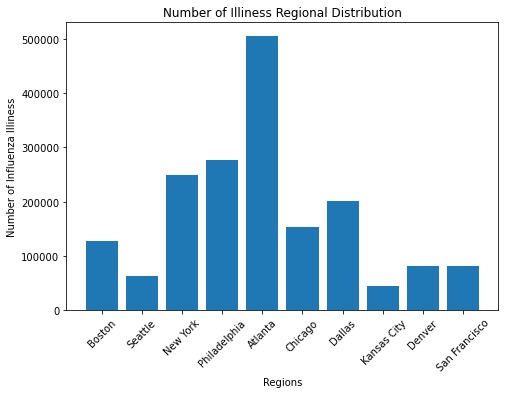

In [102]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(hhs_df["region"].tolist(),hhs_df["num_iliness"].tolist())
plt.xticks(rotation=45)
plt.title("Number of Illiness Regional Distribution")
plt.xlabel("Regions")
plt.ylabel("Number of Influenza Illiness")
plt.show()

Then we are curious about the cause of this regional distribution. Volume of transportation is usually an esential factor that could influence the number of epidemic disease cases, so we choose number of airports in the region as a possible factor.

In [ ]:
region_df['rat_ili']=region_df['num_ili']/region_df['num_patients']
region_rat=region_df.groupby("region")["region","rat_ili"].sum('num_rat').reset_index()
region_rat['rat_ili']=region_rat['rat_ili']/53
region_rat['region']=['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco']

In [161]:
# Source of airport data: https://www.globalair.com/airport/state.aspx
airport_df_temp ={'region':['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco'], 'num_airport':[866,2059,939,1610,3272,3434,3577,1459,1535,1386]}
airport_df = pd.DataFrame(data=airport_df_temp)

We draw the barcharts of regional distribution of Influenza Illiness rate and airport number and found that they have the similar trend. As a result, we guess the correlation between number of airports and Influenza Illiness rate is positive.

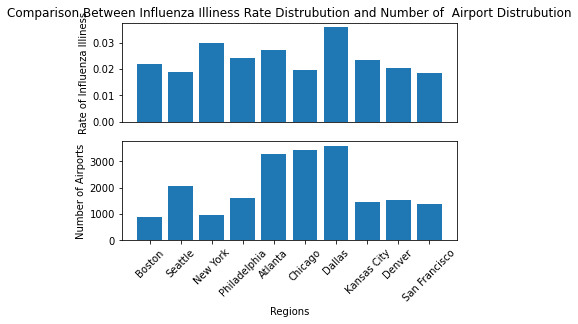

In [163]:
from matplotlib import pyplot as plt
plt.subplot(2, 1, 1) # row 1, col 2 index 1
rate=plt.bar(region_rat["region"].tolist(),region_rat["rat_ili"].tolist())
plt.xticks([],[])
plt.title("Comparison Between Influenza Illiness Rate Distrubution and Number of  Airport Distrubution")
# plt.xlabel("Regions")
plt.ylabel("Rate of Influenza Illiness")

plt.subplot(2, 1, 2) # index 2
airport=plt.bar(airport_df["region"].tolist(),airport_df["num_airport"].tolist())
plt.xticks(rotation=45)
# plt.title("Number of Airports of HHS Regions")
plt.xlabel("Regions")
plt.ylabel("Number of Airports")

plt.show()

The correlation of number of airports and Influenza Illiness rate is 0.35, which indicates that the Influenza Illiness rate tend to be high in regions that have large transportation volume.

In [164]:
region_rat["rat_ili"].corr(airport_df["num_airport"])

0.3510850896815788

**1.2 Regional Distribution In Certain Time Period**

After analyzing the regional effect, we wonder whether Influenza has seasonality. We choose summer (June to August) and winter (November to Febuary) to do the comparison.

According to the camparison of bar charts of the case number distribution in summer and winter below, the number of cases in winter is significantly larger than that in summer. So, Influenza does have seasonality.

<ipython-input-166-0e094d9294d2>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
<ipython-input-166-0e094d9294d2>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


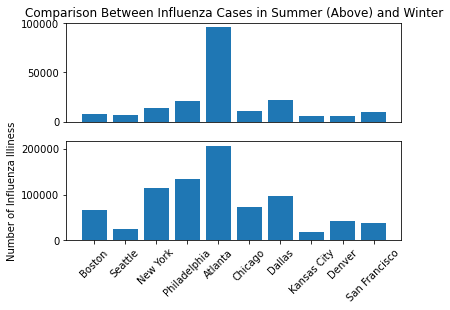

In [166]:
summer_week = [*range(202023,202036)]
region_sm = region_df.loc[region_df['epiweek'].isin(spring_week)]
region_summer = region_sm.groupby("region")["region","num_ili"].sum('num_ili').reset_index()
region_summer['region'] = ['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco']

winter_week = [*range(202049,202053), *range(202001,202009)]
region_wt = region_df.loc[region_df['epiweek'].isin(winter_week)]
region_winter = region_wt.groupby("region")["region","num_ili"].sum('num_ili').reset_index()
region_winter['region'] = ['Boston','Seattle','New York','Philadelphia','Atlanta','Chicago','Dallas',' Kansas City','Denver','San Francisco']

plt.subplot(2, 1, 1) # row 1, col 2 index 1
summer=plt.bar(region_summer["region"].tolist(),region_summer["num_ili"].tolist())
plt.xticks([],[])
plt.title("Comparison Between Influenza Cases in Summer (Above) and Winter")
# plt.xlabel("Regions")

plt.subplot(2, 1, 2) # index 2
winter=plt.bar(region_winter["region"].tolist(),region_winter["num_ili"].tolist())
plt.xticks(rotation=45)
plt.ylabel("Number of Influenza Illiness")

plt.show()